# CART — Another Example : Entropy as the split decision maker

> **Scope:** Gini impurity, Entropy (information gain), how CART chooses splits, thresholds, worked example, and sklearn snippets.

---

## 1. Quick overview

* **CART** (Classification And Regression Trees) is a decision-tree algorithm that builds binary trees by recursively splitting the dataset to increase purity.
* **Impurity measures** commonly used:

  * **Gini impurity** (default in classical CART implementations)
  * **Entropy** (a.k.a. information entropy — same measure used by ID3/C4.5)
* CART selects the split that **minimizes the weighted impurity** of the children (equivalently maximizes impurity reduction / information gain).

---

## 2. Notation (used throughout)

* Let a node contain $n$ total samples distributed across $C$ classes.
* Let $n_k$ be the number of samples of class $k$ in that node, so $p_k = n_k / n$ is the class probability.
* For a candidate split, the node is split into left (L) with $n_L$ samples and right (R) with $n_R$ samples.

All probabilities use empirical frequencies unless stated otherwise.

---

## 3. Gini impurity

**Definition:**

$$
G = 1 - \sum_{k=1}^{C} p_k^2
$$

* Interpretation: expected probability of misclassifying a randomly chosen sample if class labels were assigned according to the node class distribution.
* **Range:** $0 \le G \le 1 - \frac{1}{C}$.

  * The minimum $G=0$ occurs when the node is pure (one $p_k=1$, others $0$).
  * The maximum for a uniform class distribution $p_k = \frac{1}{C}$ is

$$
G_{\max} = 1 - \frac{1}{C}.
$$

---

## 4. Entropy (information entropy)

**Definition:**

$$
H = - \sum_{k=1}^{C} p_k \log_2(p_k)
$$

* Interpretation: measures the uncertainty (disorder) of the class distribution.
* **Range:** $0 \le H \le \log_2(C)$.

  * $H = 0$ for a pure node.
  * Maximum $H=\log_2(C)$ occurs for a uniform distribution.

**Note:** Entropy and Gini behave similarly in practice; they differ slightly in how they penalize mixed distributions.

---

## 5. Split scoring — weighted impurity and information gain

For any candidate split, compute the child impurities ($I_L$, $I_R$) where $I$ can be Gini or Entropy.

**Weighted impurity (the score CART minimizes):**

$$
\text{Score} = \frac{n_L}{n} I_L + \frac{n_R}{n} I_R
$$

**Information Gain (when using Entropy):**

$$
IG = H_{parent} - \left(\frac{n_L}{n} H_L + \frac{n_R}{n} H_R\right)
$$

* Minimizing the weighted impurity is equivalent to maximizing $IG$ (for entropy) or maximizing impurity reduction (for Gini).

---

## 6. How CART finds thresholds (finite search)

Important practical point: features are continuous or ordinal, but CART does **not** test infinitely many thresholds.

**Procedure for one feature:**

1. Sort the samples by the feature value.
2. Consider only thresholds that fall between two consecutive *distinct* feature values.

   * If sorted unique values are $v_1 < v_2 < \dots < v_k$, candidate thresholds are midpoints

$$
\frac{v_1+v_2}{2},\ \frac{v_2+v_3}{2},\ \dots,\ \frac{v_{k-1}+v_k}{2}.
$$

3. For each candidate threshold, partition the samples into left (<= threshold) and right (> threshold), compute child impurities and the weighted impurity score.
4. Repeat for every feature; choose feature+threshold with lowest weighted impurity.

**Why this is exact:** any threshold between two adjacent values produces the same partition of training samples; only partition boundaries matter.

---

## 7. Algorithm (high level)

1. Start at root node with all samples.
2. For each feature:

   * Sort samples (or use pre-sorted indices)
   * Evaluate impurity at each valid midpoint threshold
3. Pick split (feature, threshold) with minimum weighted impurity.
4. Split and recurse on child nodes until stopping criteria (max depth, min samples, purity, etc.)

**Complexity note:** naive sorting per node is costly; optimized implementations reuse sorted orders or compute cumulative statistics to evaluate splits in linear time per feature per node.

---

## 8. Worked example (entropy-based) — numeric

Parent node: $n = 100$ with two classes, class A: 40 samples, class B: 60 samples.

* Parent entropy:

[
H_{parent} = -\left(0.4\log_2 0.4 + 0.6\log_2 0.6\right) \approx 0.971,\text{bits}
]

Consider a candidate split giving:

* Left child: $n_L = 30$ with class A: 24, class B: 6 → $p_A^L = 0.8$, $p_B^L = 0.2$.

  * $H_L = - (0.8\log_2 0.8 + 0.2\log_2 0.2) \approx 0.722$ bits
* Right child: $n_R = 70$ with class A: 16, class B: 54 → $p_A^R \approx 0.2286$, $p_B^R \approx 0.7714$.

  * $H_R \approx - (0.2286\log_2 0.2286 + 0.7714\log_2 0.7714) \approx 0.787$ bits

Weighted child entropy:

$$
\text{Score} = \frac{30}{100}(0.722) + \frac{70}{100}(0.787) = 0.2166 + 0.5509 = 0.7675
$$

Information gain:

$$
IG = 0.971 - 0.7675 = 0.2035\ \text{bits}
$$

If another candidate split gives higher $IG$, that split is preferred.

---

## 9. sklearn examples

**Train a decision tree using entropy**

```python
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt.fit(X_train, y_train)
```

**Inspecting splits** (brief):

* You can visualize the tree with `sklearn.tree.plot_tree` or `export_text` to see chosen features and thresholds.

---

## 10. Entropy vs Gini — short comparison

* Both measure impurity: they usually pick similar splits.
* **Gini** is slightly faster to compute (no log) and tends to prefer larger partitions with dominant classes.
* **Entropy** (information gain) can be more sensitive to class distribution changes.

Practical rule: results rarely differ much; try both if you want to optimize performance.

---

## 11. Practical tips & FAQs

* **Q:** Does CART check every real number threshold?
  **A:** No — only midpoints between sorted unique values; this is exact for training data partitions.

* **Q:** What is the maximum possible Gini for $C$ classes?
  **A:** $1 - \frac{1}{C}$ (occurs when classes are uniform: $p_k=1/C$).

* **Q:** Is tree depth counted as edges or nodes?
  **A:** Convention varies; often *depth* is the number of edges from the root to a node (root depth = 0). If you want a different convention, state it explicitly when setting `max_depth`.

* **Q:** When should I prefer entropy over Gini?
  **A:** Rarely critical. If you want principled information-theoretic interpretation use entropy; for speed and slightly different splitting bias use Gini.

---


In [2]:
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv("Social_Network_Ads.csv")

In [4]:
df.head(2)

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0


In [5]:
df.drop(columns= ["User ID", "Gender"], inplace = True)

In [6]:
df.isnull().sum() #no null value

Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

In [7]:
x = df.iloc[:,:-1]

In [8]:
y = df["Purchased"]

In [9]:
df.head(2)

,Age,EstimatedSalary,Purchased
0,19,19000,0
1,35,20000,0


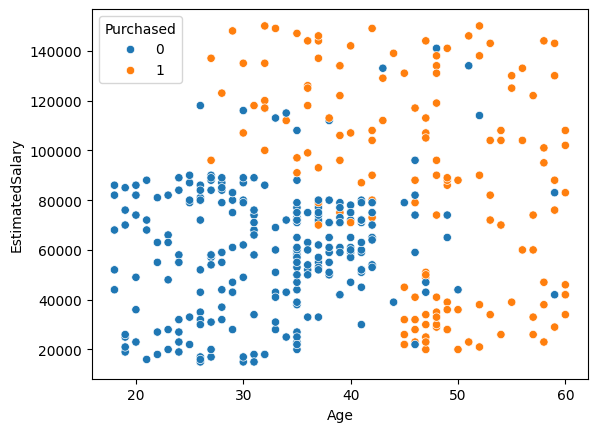

In [10]:
import seaborn as sns

sns.scatterplot(
    x = 'Age',
    y = 'EstimatedSalary',
    data = df,
    hue = "Purchased"
)
plt.show()

In [11]:
# data in age and salary is to big in numbers in comparison to purchased so we need to scale it
from sklearn.preprocessing import StandardScaler

In [12]:
ss = StandardScaler()

In [13]:
ss.fit(x)

StandardScaler()

In [14]:
x  = pd.DataFrame(data = ss.transform(x), columns = x.columns)

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

### now importing CART

In [ ]:
from sklearn.tree import DecisionTreeClassifier #DecisionTreeClassifier uses CART algorithm

In [18]:
dtc = DecisionTreeClassifier(
    criterion = "entropy") #cart

In [19]:
dtc.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [20]:
dtc.score(x_test, y_test)*100

83.75

In [21]:
y_pred = dtc.predict(x_test)

## Plotting Decision Boundary

In [24]:
from mlxtend.plotting import plot_decision_regions

/home/akash/myEnv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


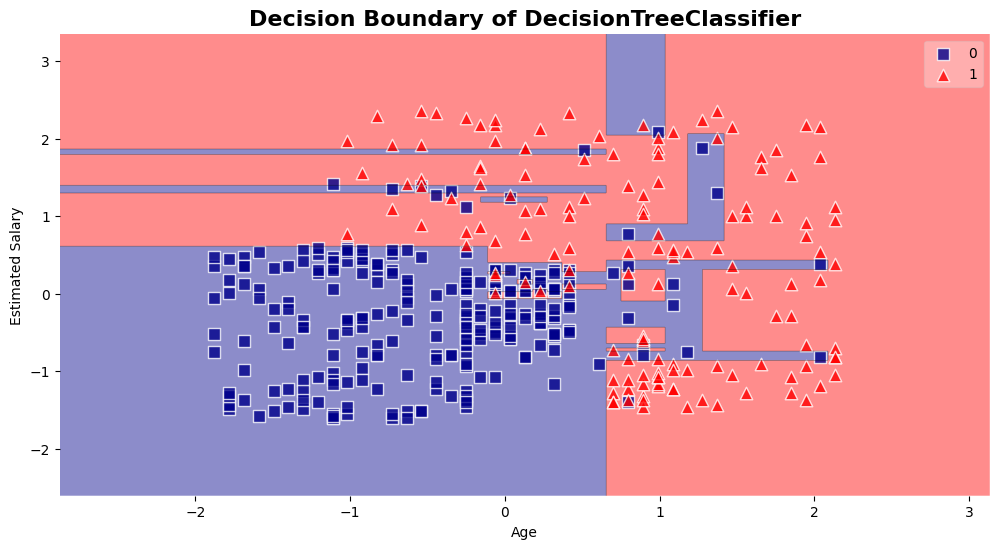

In [ ]:
plt.figure(figsize = (12,6))
plt.title("Decision Boundary of DecisionTreeClassifier", fontweight = 'bold', fontsize = 16)

plot_decision_regions(
    X= x.to_numpy(),
    y= y.to_numpy(),
    clf = dtc,
    colors = "darkblue,red",
    scatter_kwargs={"s" : 80, "edgecolor" : "white", "alpha" : 0.8, "linewidth" : 1},
    contour_kwargs={"alpha" : 0.4}, #this parameter contorls transparency of outer lining of decision regions
    legend = 1
    
)

plt.xlabel("Age")
plt.ylabel("Estimated Salary")
plt.show()

## Plotting Tree

In [22]:
# graph analysis

from sklearn.tree import plot_tree

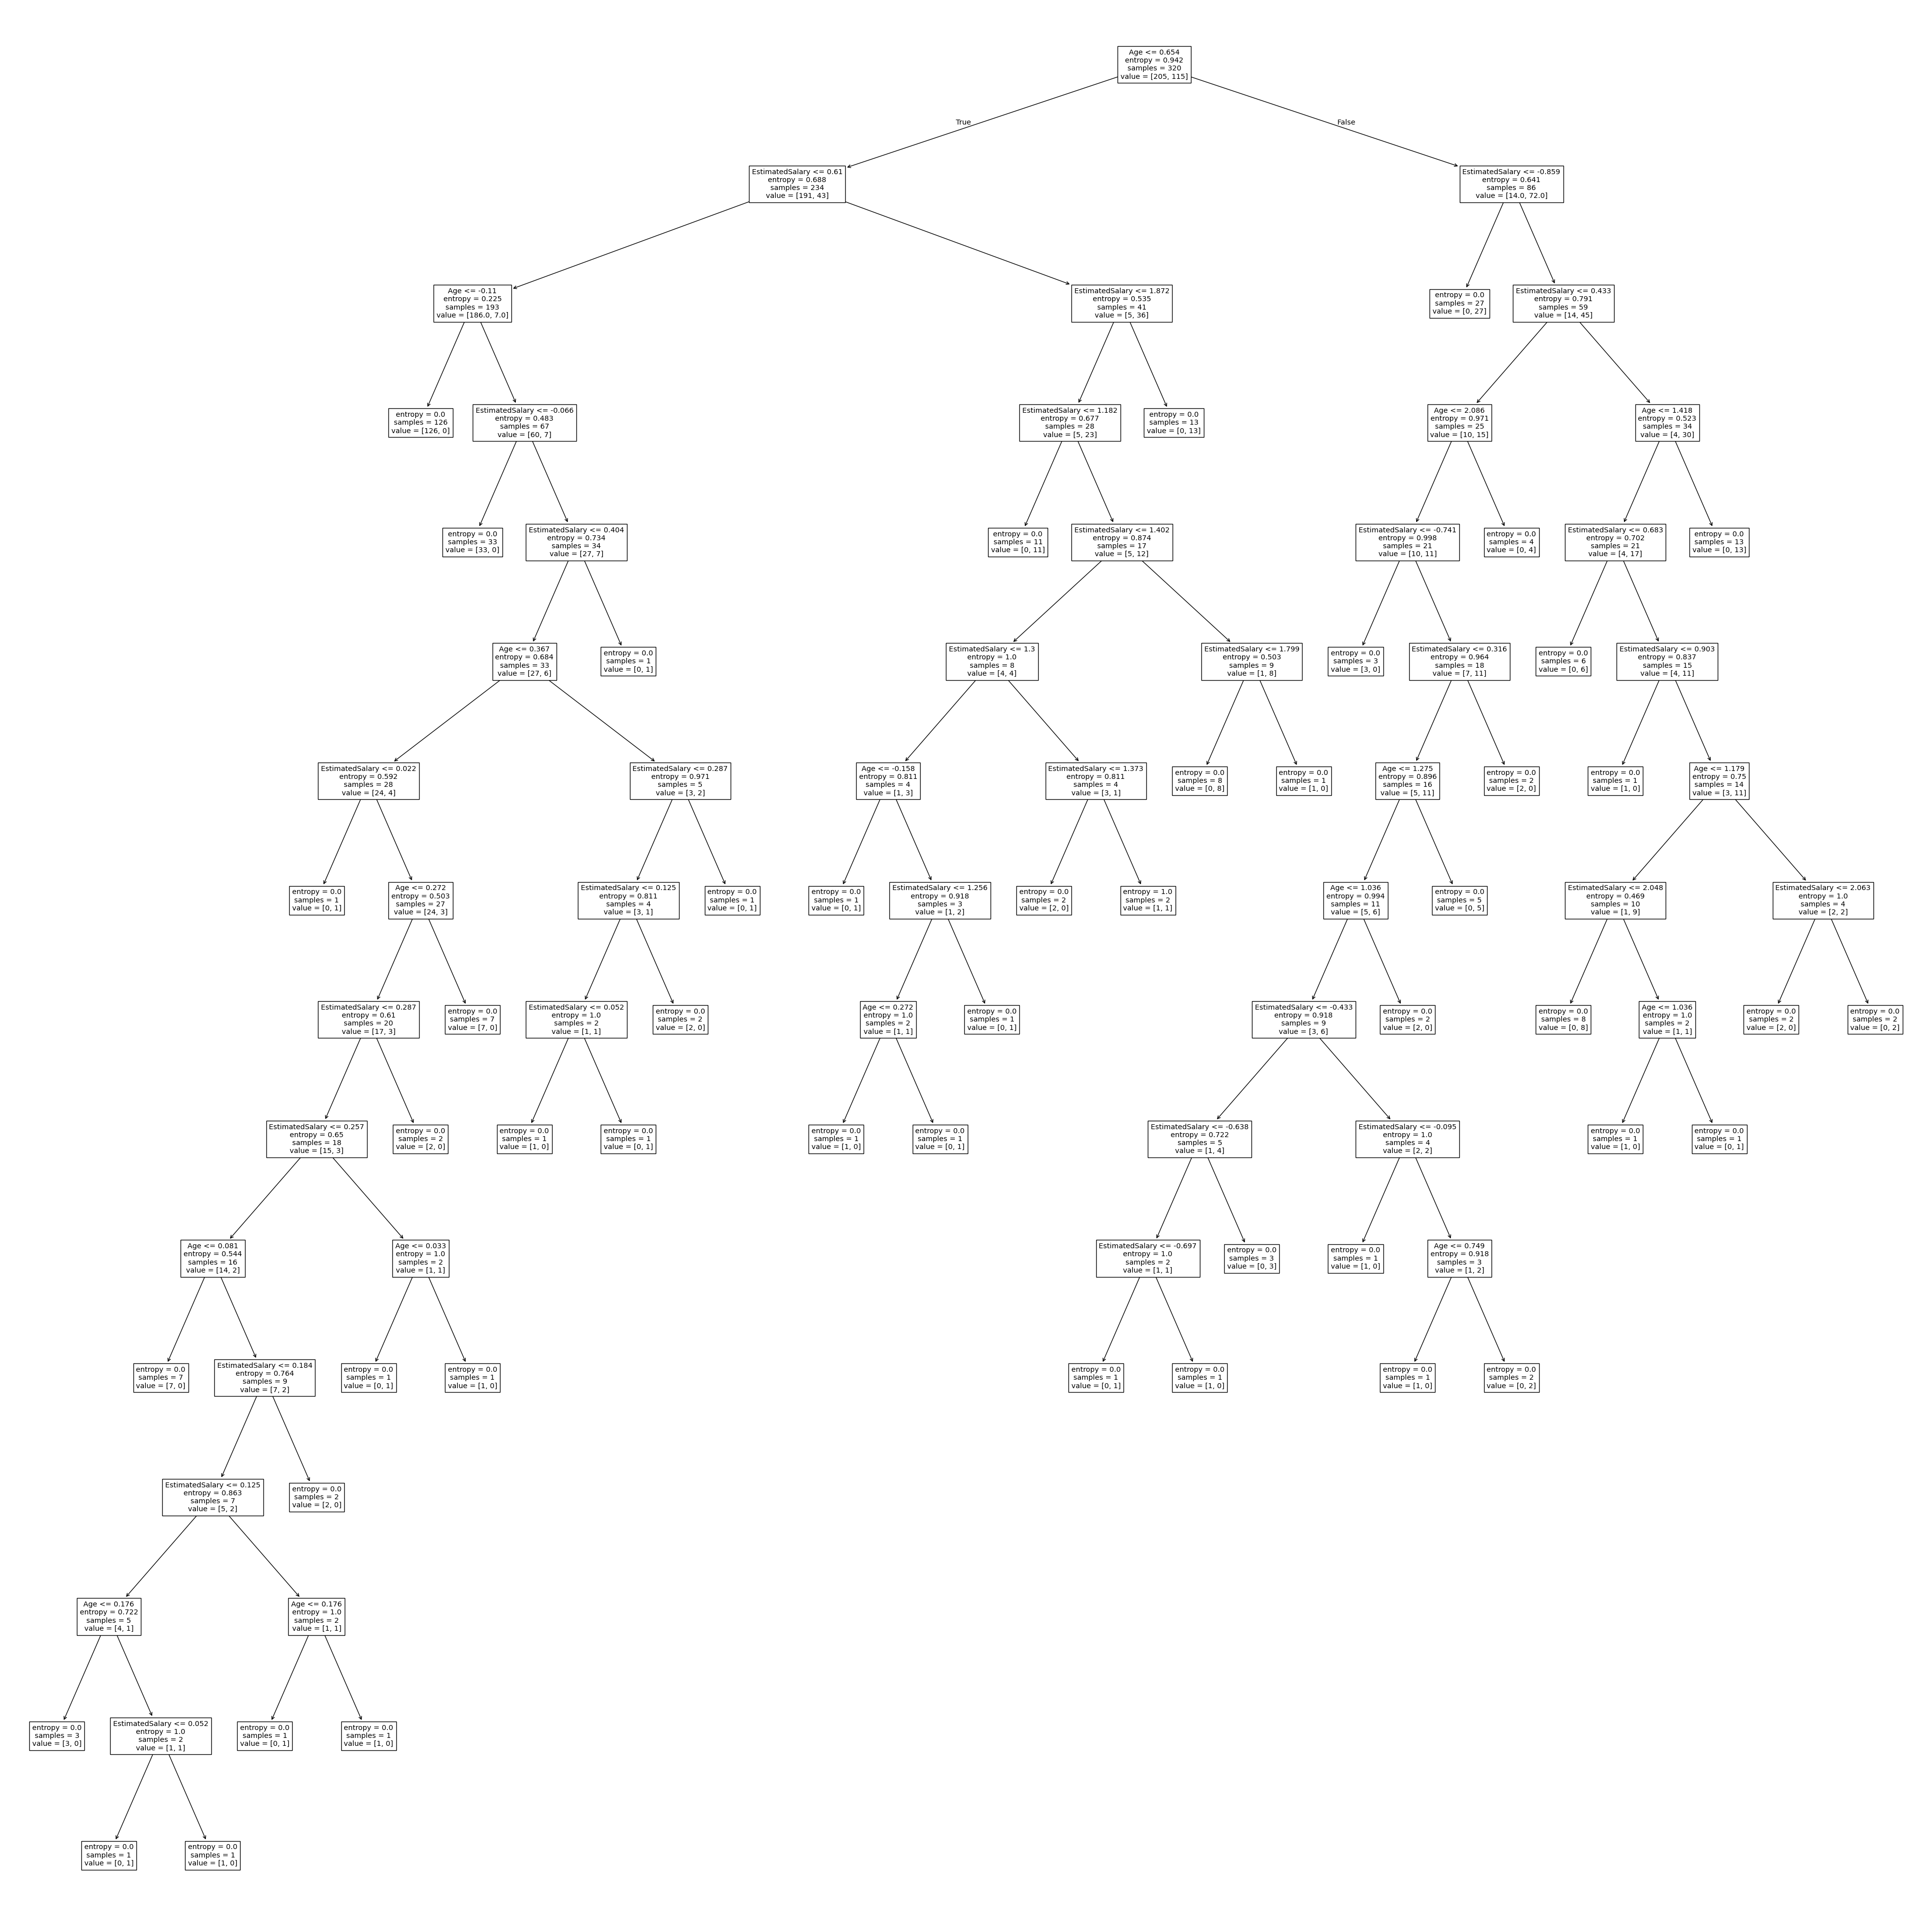

In [23]:
plt.figure(figsize = (50,50))

plot_tree(
    decision_tree=dtc,
    feature_names= x.columns
    
    )
plt.show()